In [28]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
path = "https://pages.cs.wisc.edu/~harter/cs639/data/wi-stations/USW00014837.csv.gz"
df = pd.read_csv(path, names=["station", "date", "element", "value", "m", "q", "s", "obs"])

#https://pages.cs.wisc.edu/~harter/cs639/data/wi-stations/USW00014839.csv.gz

/tmp/ipykernel_180336/1707958151.py:5: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path, names=["station", "date", "element", "value", "m", "q", "s", "obs"])


In [2]:
df
#for same station+date, there are mult rows bc diff measurements they are taking at diff regularity
#looking for min and max temp
df["element"]
df["element"].isin(["TMIN", "TMAX"]) #for each value in column, is it one of TMIN or TMAX? figuring out which rows to care about

0          True
1          True
2          True
3          True
4          True
          ...  
409846    False
409847    False
409848    False
409849    False
409850    False
Name: element, Length: 409851, dtype: bool

In [3]:
df2 = df[df["element"].isin(["TMIN", "TMAX"])] #filters to only rows that eval to True
df2.head()

,station,date,element,value,m,q,s,obs
0,USW00014837,19391001,TMAX,194,NaN,NaN,X,NaN
1,USW00014837,19391002,TMAX,211,NaN,NaN,X,NaN
2,USW00014837,19391003,TMAX,233,NaN,NaN,X,NaN
3,USW00014837,19391004,TMAX,272,NaN,NaN,X,NaN
4,USW00014837,19391005,TMAX,211,NaN,NaN,X,NaN


In [4]:
# GOAL: predict TMAX given TMIN
#need to get x and y in same row - use pd.pivot
#want 1 row per date (index)
#want the values in element column to be column header values
temps = df2.pivot(index="date", columns="element", values="value")
temps.head()

element,TMAX,TMIN
date,,
19391001,194,6
19391002,211,33
19391003,233,89
19391004,272,106
19391005,211,133


<AxesSubplot: xlabel='TMIN', ylabel='TMAX'>

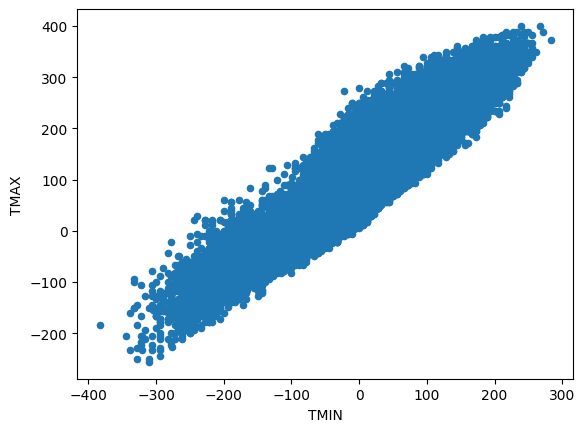

In [5]:
temps.plot.scatter(x="TMIN", y="TMAX")
#promising! can prob make predictions

In [6]:
# PyTorch Data:
# 1. Dataset (in charge of assigning a number to each piece of data)
# 2. DataLoader: use DataSet, but provide shuffling and batching 

In [7]:
#torch.utils.data.TensorDataset(X, Y) #can give it tensors to learn over. p1

#temps[["TMAX"]] gives dataframe w just that cov
torch.tensor(temps[["TMAX"]].values, dtype=torch.float32) 

tensor([[194.],
        [211.],
        [233.],
        ...,
        [ 28.],
        [ 22.],
        [  0.]])

In [8]:
ds = torch.utils.data.TensorDataset(
    torch.tensor(temps[["TMIN"]].values, dtype=torch.float32), # X values
    torch.tensor(temps[["TMAX"]].values, dtype=torch.float32)) # Y values

In [9]:
ds[1] #looking at diff positions

(tensor([33.]), tensor([211.]))

In [10]:
type(ds).__mro__


(torch.utils.data.dataset.TensorDataset,
 torch.utils.data.dataset.Dataset,
 typing.Generic,
 object)

In [11]:
#instead of using tensor dataset, can build out own dataset time from scratch 
#so that we not need all data in memory at once

In [12]:
class TempDS(torch.utils.data.dataset.Dataset): #making a dataset. in parenth helps it inherit from other sites (methods, etc)
    def __init__(self, path): #constructor
        #get data
        df = pd.read_csv(path, names=["station", "date", "element", "value", "m", "q", "s", "obs"])
        #filter it
        df2 = df[df["element"].isin(["TMIN", "TMAX"])]
        #pivot
        temps = df2.pivot(index="date", columns="element", values="value")
        #get x and y values, set as attributes
        self.X = torch.tensor(temps[["TMIN"]].values, dtype=torch.float32)
        self.Y = torch.tensor(temps[["TMAX"]].values, dtype=torch.float32)
     
    def __getitem__(self, index):
        return self.X[index], self.Y[index]
    
    def __len__(self):
        return len(self.X)
    
    
ds = TempDS("https://pages.cs.wisc.edu/~harter/cs639/data/wi-stations/USW00014837.csv.gz")


/tmp/ipykernel_180336/2839003345.py:4: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path, names=["station", "date", "element", "value", "m", "q", "s", "obs"])


In [13]:
ds[1] #can use brackets thanks to __getitem__

(tensor([33.]), tensor([211.]))

In [14]:
ds[:5] #get first 5 X and y values

(tensor([[  6.],
         [ 33.],
         [ 89.],
         [106.],
         [133.]]),
 tensor([[194.],
         [211.],
         [233.],
         [272.],
         [211.]]))

In [15]:
ds[:] # get all of both x and y values

(tensor([[  6.],
         [ 33.],
         [ 89.],
         ...,
         [  0.],
         [  0.],
         [-32.]]),
 tensor([[194.],
         [211.],
         [233.],
         ...,
         [ 28.],
         [ 22.],
         [  0.]]))

In [16]:
len(ds) #can use len() thanks to __len__

30428

In [17]:
len(ds+ds)

60856

In [18]:
ds2 = TempDS("https://pages.cs.wisc.edu/~harter/cs639/data/wi-stations/USW00014839.csv.gz")
len(ds + ds2)

/tmp/ipykernel_180336/2839003345.py:4: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path, names=["station", "date", "element", "value", "m", "q", "s", "obs"])


61404

In [19]:
dl = torch.utils.data.DataLoader(ds, shuffle=True, batch_size=10)
#passing in a dataset
#can loop over dataloader
#batch = 10 means 10 x and 10 y values

In [20]:
for x, y in dl:
    print(x)
    print(y)
    break
    
#EXAMPLE QUESTION: 
#i have this much RAM
# each row of x and y are this large
# what is biggest batch size i can do without runnning out of RAM?

tensor([[  39.],
        [-272.],
        [ -22.],
        [ -22.],
        [ -83.],
        [  11.],
        [ 100.],
        [ 117.],
        [-233.],
        [ 178.]])
tensor([[  89.],
        [-144.],
        [  22.],
        [ 150.],
        [  67.],
        [ 183.],
        [ 294.],
        [ 283.],
        [-100.],
        [ 294.]])


In [21]:
# review: Dataset, DataLoader, Model, Optimizer, Loss Function

# model:
# tmax = model(tmin) = tmin * weight + bias

In [22]:
model = torch.nn.Linear(1, 1) # set up linear model. 1 input (x) and 1 output value (y)
optimizer = torch.optim.SGD([model.weight, model.bias], lr=0.00001) #want to optimize weight and bias, that's why theyre in there
loss_fn = torch.nn.MSELoss() #loss function we will use


# machine learning loop ML loop
for epoch in range(50):
    for batchx, batchy in dl:
        predictedy = model(batchx) #model predictions based on those x values
        loss = loss_fn(batchy, predictedy) #loss function that relates batchy to predY
        # change model params based on loss?:
        loss.backward()         # update weight.grad and bias.grad
        optimizer.step()        # update weight and bias based on the gradients
        optimizer.zero_grad()   # weight.grad = 0 and bias.grad = 0
        
        
    # how well are we doing?
    #hopefully MSE is decreasing
    x, y = ds[:]
    print(epoch, loss_fn(y, model(x)))
    
    #if u are getting nan, then learning rate probably too big. 

0 tensor(12763.1816, grad_fn=<MseLossBackward0>)
1 tensor(11867.0547, grad_fn=<MseLossBackward0>)
2 tensor(11316.8291, grad_fn=<MseLossBackward0>)
3 tensor(9639.0508, grad_fn=<MseLossBackward0>)
4 tensor(8878.0977, grad_fn=<MseLossBackward0>)
5 tensor(8067.3003, grad_fn=<MseLossBackward0>)
6 tensor(7427.7832, grad_fn=<MseLossBackward0>)
7 tensor(6837.5112, grad_fn=<MseLossBackward0>)
8 tensor(6413.0288, grad_fn=<MseLossBackward0>)
9 tensor(5807.0146, grad_fn=<MseLossBackward0>)
10 tensor(5394.8237, grad_fn=<MseLossBackward0>)
11 tensor(5143.9424, grad_fn=<MseLossBackward0>)
12 tensor(4739.0225, grad_fn=<MseLossBackward0>)
13 tensor(4412.4678, grad_fn=<MseLossBackward0>)
14 tensor(4153.4009, grad_fn=<MseLossBackward0>)
15 tensor(3969.4292, grad_fn=<MseLossBackward0>)
16 tensor(3729.3872, grad_fn=<MseLossBackward0>)
17 tensor(3755.8279, grad_fn=<MseLossBackward0>)
18 tensor(3384.7769, grad_fn=<MseLossBackward0>)
19 tensor(3229.2310, grad_fn=<MseLossBackward0>)
20 tensor(3123.5469, grad_f

In [23]:
model.weight, model.bias

(Parameter containing:
 tensor([[1.0632]], requires_grad=True),
 Parameter containing:
 tensor([105.3282], requires_grad=True))

In [25]:
tmin = torch.arange(-400,300, dtype = torch.float32) #trying all numbers in this range
predicted_tmax = model(tmin.reshape(-1,1)).reshape(-1)


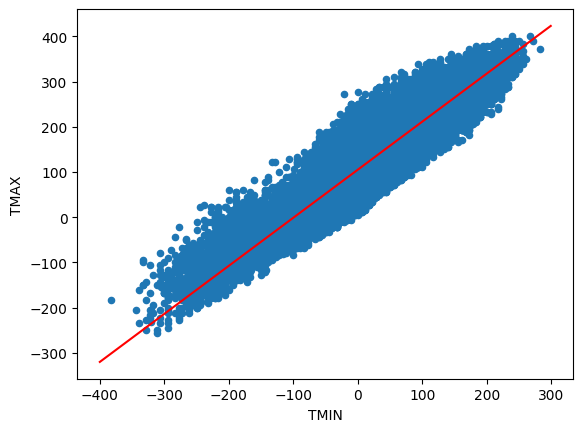

In [29]:
temps.plot.scatter(x="TMIN", y="TMAX")
plt.plot(tmin, predicted_tmax.detach(), "r") #.detach(): don't need to track anymore. (idk see min 21)